In [1]:
%matplotlib inline
import xarray as xr
import climpred
import proplot as plot
import numpy as np
import esmtools as et
import scipy

In [2]:
# Import utility scripts. Better than wrangling a whole project install.
import sys
sys.path.insert(1, '../')
import util

In [3]:
print(climpred.__version__)

2.0.0.post3


# Compute Critical Values for R*

In [15]:
ds = xr.open_dataset('area_weighted_products.nc')

In [16]:
from scipy.stats import t
p = 0.05 # two-tailed
p = p /2

df = climpred.prediction.compute_hindcast(ds.hind, ds.fosi, metric='eff_n', max_dof=True)

tval = t.ppf(p, df)
r = tval / (np.sqrt(df + tval**2))
np.round(r*-1, 3)

/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/climpred/utils.py:49: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


<xarray.DataArray (lead: 10)>
array([0.285, 0.294, 0.297, 0.285, 0.279, 0.288, 0.291, 0.297, 0.304,
       0.304])
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10


# Panel A analysis: Area-weighted ACCs

```python
# Load in DPLE and area-weight
filepath = '/glade/work/rbrady/projects/CalCS_decadal_prediction/CESM-DPLE_annual/1964_2014/'
dple = xr.open_dataset(filepath + 'CCS.PH.anom.1964_2014.nc').PH
area = dple.TAREA.where(dple.isel(init=0, lead=0).notnull())
dple = (dple * area).sum(['nlat', 'nlon']) / area.sum()

# Load in FOSI and lens
fosi = util.load_FOSI(var='PH', annual=True, areaweight=True, mask_LME=True)
lens = util.load_uninitialized(var='PH', annual=True, areaweight=True, mask_LME=True)
lens = lens.sel(time=slice(1948, 2017))

# Make anomalies.
fosi = fosi - fosi.sel(time=slice(1964, 2014)).mean()
lens = lens - lens.sel(time=slice(1964, 2014)).mean()

# Detrend
dple = et.stats.rm_poly(dple, order=2, dim='init')
fosi = et.stats.rm_poly(fosi, order=2, dim='time')
lens = et.stats.rm_poly(lens, order=2, dim='time')

ds = xr.Dataset()
ds['hind'] = dple
ds['fosi'] = fosi
ds['lens'] = lens

ds.to_netcdf('area_weighted_products.nc')
```

In [17]:
init_acc = climpred.prediction.compute_hindcast(ds.hind,
                                                ds.fosi,
                                                metric='acc',
                                                max_dof=True)
persist_acc = climpred.prediction.compute_persistence(ds.hind,
                                                      ds.fosi,
                                                      metric='acc',
                                                      max_dof=True)
uninit_acc = climpred.prediction.compute_uninitialized(ds.hind,
                                                       ds.lens,
                                                       ds.fosi,
                                                       metric='acc',
                                                       max_dof=True)

init_p = climpred.prediction.compute_hindcast(ds.hind,
                                                ds.fosi,
                                                metric='pearson_r_eff_p_value',
                                                max_dof=True)
persist_p = climpred.prediction.compute_persistence(ds.hind,
                                                      ds.fosi,
                                                      metric='pearson_r_eff_p_value',
                                                      max_dof=True)
uninit_p = climpred.prediction.compute_uninitialized(ds.hind,
                                                       ds.lens,
                                                       ds.fosi,
                                                       metric='pearson_r_eff_p_value',
                                                       max_dof=True)


# Panel B Analysis: NMAE

In [18]:
init_bias = climpred.prediction.compute_hindcast(ds.hind,
                                                 ds.fosi,
                                                 metric='nmae',
                                                 max_dof=True)
persist_bias = climpred.prediction.compute_persistence(ds.hind,
                                                 ds.fosi,
                                                 metric='nmae',
                                                 max_dof=True)
uninit_bias = climpred.prediction.compute_uninitialized(ds.hind,
                                                 ds.lens,
                                                 ds.fosi,
                                                 metric='nmae',
                                                 max_dof=True)

In [20]:
init_bias<1

<xarray.DataArray (lead: 10)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10

In [22]:
persist_bias

<xarray.DataArray 'fosi' (lead: 10)>
array([0.93854975, 1.01464993, 1.12600514, 1.19521339, 1.1245983 ,
       1.1950902 , 1.09894017, 1.17250804, 1.18445605, 1.29506895])
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10

In [21]:
persist_bias<1

<xarray.DataArray 'fosi' (lead: 10)>
array([ True, False, False, False, False, False, False, False, False,
       False])
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10

# Panel C: Driver Variables

```python
sensitivity = {'SST': -0.0153,
               'sALK': 0.00251,
               'ALK': 0.00251,
               'sDIC': -0.0017,
               'DIC': -0.0017,
               'SSS': -0.01342,}

scaled = {}
for DRIVER_VARIABLE in ['SST', 'SSS', 'sDIC', 'sALK']:
    print(f'{DRIVER_VARIABLE}...')
    # Load in
    dple = xr.open_dataarray(basepath + f'area_weighted_LME/{DRIVER_VARIABLE}_aw.DPLE.CalCS.1955-2018.nc').mean('member')
    dple['init'] = dple['init'] - 1
    fosi = xr.open_dataarray(basepath + f'area_weighted_LME/{DRIVER_VARIABLE}_aw.FOSI.CalCS.1948-2017.nc')
    
    # Create anomalies
    fosi = fosi - fosi.sel(time=slice(1964, 2014)).mean()

    # Detrend
    dple = cp.stats.rm_poly(dple, order=1, dim='init')
    fosi = cp.stats.rm_poly(fosi, order=1, dim='time')
    
    # correlation coefficient
    r = cp.prediction.compute_hindcast(dple, fosi, max_dof=False)

    # sigma
    sigma = fosi.std('time')

    # sensitivity
    scaled[DRIVER_VARIABLE] = np.abs(sensitivity[DRIVER_VARIABLE]) * r * sigma
```

In [4]:
filepath = '/glade/work/rbrady/projects/CalCS_decadal_prediction/driver_variables/driver_variables_area_weighted.nc'

In [5]:
scaled = xr.open_dataset(filepath)

# Visualize!

In [10]:
def plot_panel_a(ax, acc, pval, color, **kwargs):
    """
    Plots lines for panel A with significance.
    """
    ax.plot(acc.lead, 
            acc, 
            linewidth=2, 
            marker='o', 
            markersize=8,
            markerfacecolor='w', 
            color=color,
            **kwargs)
    
    condition = (pval <= 0.05) & (acc >= 0)
    ax.plot(acc.where(condition).lead,
            acc.where(condition),
            markeredgewidth=2,
            linestyle='None',
            marker='o',
            markersize=8,
            markeredgecolor='None',
            markerfacecolor=color)
    
def plot_panel_a_stars(ax, 
                       acc1, 
                       acc2,
                       p1,
                       color, 
                       label,
                       bottom=True
                       ):
    """
    Plots z-test significance stars for panel A.
    
    acc1 : skill ACC
    acc2 : persist or uninit acc
    p1 : pvalue from init ACC
    bottom : True for bottom star (FOSI)
    """
    N = climpred.prediction.compute_hindcast(ds.hind, ds.fosi, max_dof=True, metric='eff_n')
    zsig = util.z_significance(acc1, acc2, 64, ci=95)
    stars = acc1.where((zsig) & (p1 <= 0.05))
    
    if bottom:
        delta = 0.12
    else:
        delta = 0.2
    
    p = ax.plot(stars.lead,
            stars + delta,
            color=color,
            marker=(6,2,0),
            markersize=6,
            markeredgewidth=0.5,
            linestyle='None',
            label=label)
    return p
    
def plot_panel_b(ax, mae, color, label, **kwargs):
    """
    Plots lines for panel A with significance.
    """
    p = ax.plot(mae.lead, 
                mae, 
                linewidth=2, 
                color=color, 
                label=label,
                **kwargs)
    return p

/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/climpred/utils.py:49: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '
/glade/u/home/rbrady/miniconda3/envs/analysis/lib/python3.6/site-packages/climpred/utils.py:49: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


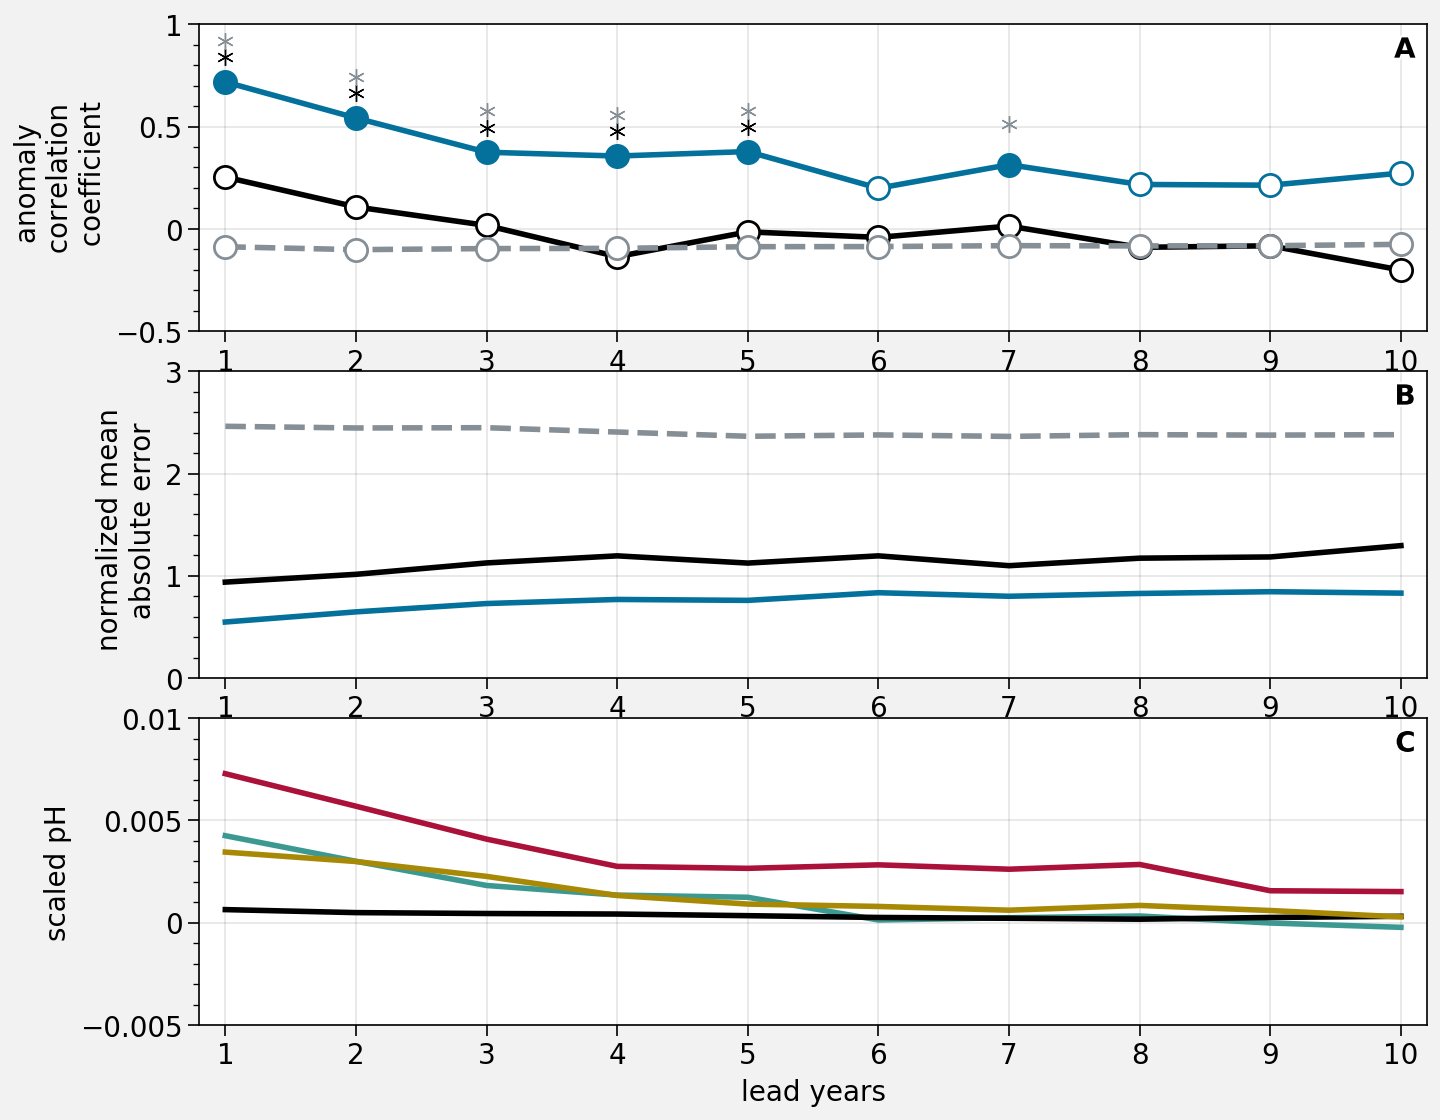

In [11]:
DPLE_COLOR = 'ocean blue'
FOSI_COLOR = 'k'
LENS_COLOR = 'gray6'
DRIVER_COLORS = {
    'sDIC': '#AB1239',
    'SST': '#3C9992',
    'sALK': '#A88905',
    'SSS': 'k',
    }

plot.rc.fontname = 'Helvetica'
plot.rc.small = 10
plot.rc.large = 10
plot.rc['abc.size'] = 10

f, axs = plot.subplots(journal='nat2',
                       nrows=3, 
                       aspect=4,
                       sharex=True, 
                       sharey=False, 
                       spany=False,
                       tight=True,
                        hspace=0.2
                      )

# ====================
#   FIG 3A : ACC
# ====================
# Filled dots for correlation significance.
plot_panel_a(axs[0], init_acc, init_p, DPLE_COLOR)
plot_panel_a(axs[0], persist_acc, persist_p, FOSI_COLOR)
plot_panel_a(axs[0], uninit_acc, uninit_p, LENS_COLOR, linestyle='--')

# # Significance stars above each dot.
p1, = plot_panel_a_stars(axs[0], init_acc, persist_acc, init_p, FOSI_COLOR, 'significant over persistence')
p2, = plot_panel_a_stars(axs[0], init_acc, uninit_acc, init_p, LENS_COLOR, 'significant over uninitialized',
                   bottom=False)
axs[0].format(ylim=[-0.5, 1],
              ylabel='anomaly \n correlation \n coefficient')
#axs[0].legend([p1, p2], loc='lr', center=True)

# ====================
#   FIG 3B : MAE
# ====================
p1, = plot_panel_b(axs[1], init_bias, DPLE_COLOR, 'initialized')
p2, = plot_panel_b(axs[1], persist_bias, FOSI_COLOR, 'persistence')
p3, = plot_panel_b(axs[1], uninit_bias, LENS_COLOR, 'uninitialized', linestyle='--')


axs[1].format(ylim=[0, 3],
              ylabel='normalized mean \n absolute error')
#axs[1].legend([p1, p2, p3], loc='lr')

# ====================
#   FIG 3C : DRIVER
# ====================
handles = []
for DRIVER_VARIABLE in ['SST', 'SSS', 'sDIC', 'sALK']:
    da = scaled[DRIVER_VARIABLE]
    p, = axs[2].plot(da.lead,
                     da,
                     color=DRIVER_COLORS[DRIVER_VARIABLE],
                     label=DRIVER_VARIABLE,
                     linewidth=2)
    handles.append(p)
axs[2].format(ylim=[-0.005, 0.01],
              ylabel='scaled pH')
#axs[2].legend([handles], loc='lr')
    
# ====================
#   AESTHETICS
# ====================  
axs.format(xlim=[0.8, 10.2], 
           abc=True, 
           abcloc='ur', 
           abcstyle='A',
           xticks=plot.arange(1, 10),
           xticklabels=[str(i) for i in plot.arange(1, 10)],
           xtickminor=False,
           xlabel='lead years')

# f.savefig('../figures/figure4/figure4.pdf')